## Finding the best images from the Generative VAE model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn

In [3]:
from src.generative.model import VAE
from src.generative.utils import get_latent_dim, generate_and_filter_images

### Loading in the Sensor Data

In [5]:
# Loading in the Observation Data
obs_dataset = 'Data/Ferguson_fire_obs.npy' 
obs_dataset = np.load(obs_dataset)
obs_dataset_last = obs_dataset[-1:,]

## Loading in the pre-trained model

I am using the VAE that we trained with 2 hidden layers [1024, 128] with a latent space of 16 using ReLU as the activation. To look more at the parameter selection and the training - take a look at the ```FCVAE_gridsearch.ipynb```. Here we load in the model to then utilize to generate wildfire images.

In [6]:
# Define the saved model path
model_path = 'VAE_1024_128_bs32_lr001_ld16.pt'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Set Device
 
# Initialize the model (from Class)
model = VAE(input_image_dims=(1, 256, 256),
            hidden_layers=[1024, 128],
            latent_dims=16,
            activation=nn.ReLU,
            device=device).to(device)

# Load the model state dictionary with map_location to handle the CPU-only environment
state_dict = torch.load(model_path, map_location=device)

# Load the model state dictionary
model.load_state_dict(
        torch.load(model_path, map_location=torch.device(device))["model_state_dict"]
    )

# Print the model to confirm
print(model)

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=65536, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=128, bias=True)
    (3): ReLU()
  )
  (_mu): Linear(in_features=128, out_features=16, bias=True)
  (_logvar): Linear(in_features=128, out_features=16, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=65536, bias=True)
    (5): Sigmoid()
  )
)


In [7]:
get_latent_dim(model) # See if latent is correct

16

We gather the pixel value information from the observation images in order to figure out a threshold to use when comparing the image to the observation. This will hopefully enable us to narrow down the images that we then compare with MSE. 

In [8]:
obs_image_idx = [] # Index of the observation image
obs_percent_1 = [] # Percent of pixel values with value 1
obs_percent_0 = [] # Percent of pixel values with value 0

# Loop through the observation dataset to get the percentage of pixel values with value 1 and 0
for i in range(len(obs_dataset)):
    obs_image = obs_dataset[i]
    obs_image_idx.append(i)
    obs_percent_1.append((np.sum(obs_image == 1) / np.prod(obs_image.shape)) * 100)
    obs_percent_0.append((np.sum(obs_image == 0) / np.prod(obs_image.shape)) * 100)

print(f'Percentages of pixel values with value 1: {obs_percent_1}')
print(f'Percentages of pixel values with value 0: {obs_percent_0}')

Percentages of pixel values with value 1: [5.0048828125, 8.6517333984375, 10.430908203125, 12.1124267578125, 13.56048583984375]
Percentages of pixel values with value 0: [94.9951171875, 91.3482666015625, 89.569091796875, 87.8875732421875, 86.43951416015625]


Here we see that the pixel ranges for the "activated" pixels are between 5 and 13.56 percent. This means that we can use this metric to select generated images with an activated percentage within that range.

## Finding the closest generated image to the observation images

Using the ```generate_and_filter_images``` function from ```utils.py``` we can use our trained model to generate a certain number of images and then test each image's pixel ratio given the ratio we designate (in this case the range 3-15% from above). These filtered images are then iteratively compared to each satellite image and the MSE and SSIM are calculated and the 'best images' are chosen based on given criteria. The best image (with the lowest MSE) is displayed and then all the filtered images are then compared against it to find images that match our 'best' image so that we may use them in Data Assimilation to train a PCA model as well as use our 'best image' to assimilate the satellite image with.

Total Valid Generated Images: 1068


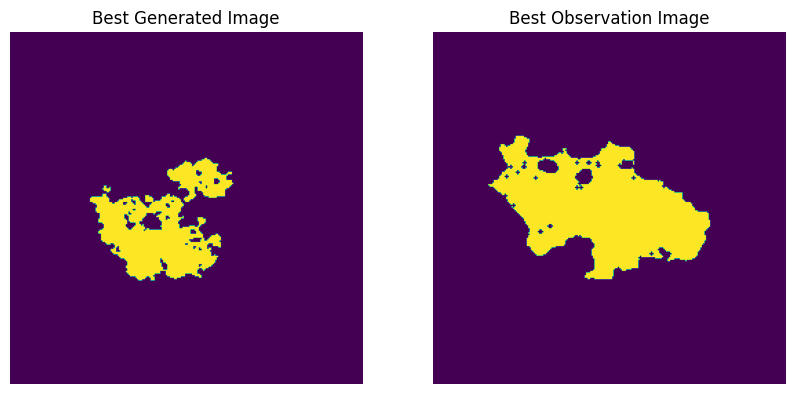

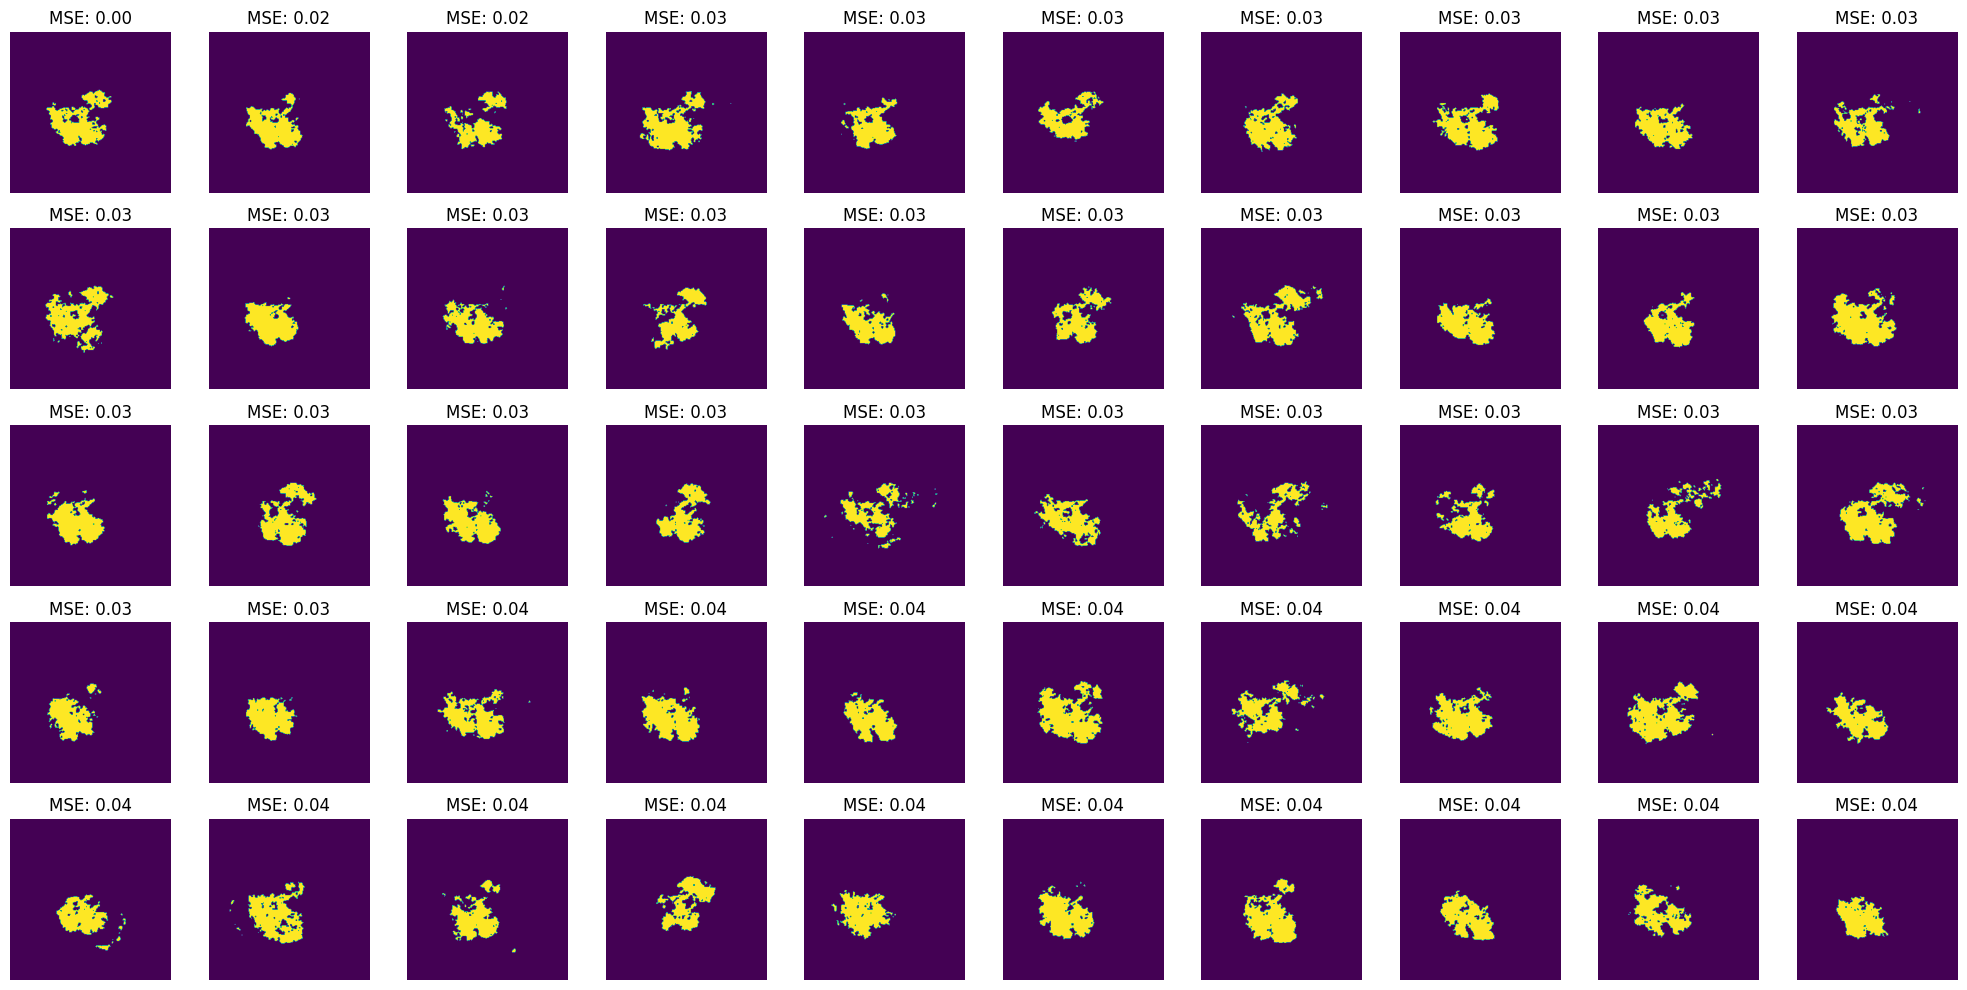

Lowest MSE: 0.1009521484375
Best Observation Image Index: 0


In [10]:
# Use the generate_and_filter_images function to generate images and pick the best
filtered_generated_images, best_generated_image, best_obs_image, best_obs_index, lowest_mse, top_images, top_mses = generate_and_filter_images(
    model,
    obs_dataset_last,
    device='cpu',
    num_samples=8000,
    pixel_ratio_range=(5, 14),
    num_images=50,
    threshold=0.70  # Adjusted threshold value to capture slightly activated pixels
)

print(f'Lowest MSE: {lowest_mse}')
print(f'Best Observation Image Index: {best_obs_index}')

Here, we have chosen to create 50 images that have the lowest MSE compared with our 'best image'. And as you can see, they all pretty closely follow the same structure so we can argue that there is a sequence in here or a ```t+1```. We are also given the MSE of the 'best image' as well as teh index of the chosen satellite image if we give it all 5 images. In our example, we have explicity chosen the last satellite image when we created ```obs_dataset_last = obs_dataset[-1:,]``` and therefore we are forcing this function to only search for images closest to the last satellite image (the index therefore can only be 0 as there is one image). 

We found that when we gave the function all observation images, it tended to always chose the first observation image - as this one has the lowest pixel activation ratio of the five, therefore making it an easier 'ratio' to meet. We did sometimes get an image that was closer to the 2nd or 3rd observation image but it was more rare.

#### Saving the images as np arrays to use in Data Assimilation

In [ ]:
# # Save the extracted images
# best_100 = np.array(top_images)

# # Save the extracted images
# np.save(f"top_background_100.npy", best_100)

# # Save the best generated image
# np.save(f"best_background_assimilate_2.npy", best_generated_image)

### Example of how to save a specific ordering of images to capture the propogation of a wildfire

In [ ]:
# # choosing the indices
# idx_plot = [7, 2, 8, 1, 0, 9, 3]

# # plot top images chosen
# fig, ax = plt.subplots(1, 7, figsize=(20, 20))
# for i, idx in enumerate(idx_plot):
#     ax[i].imshow(top_images[idx], cmap='viridis')
#     ax[i].set_title(f"Top {i+1}\nMSE: {top_mses[idx]:.4f}")
#     ax[i].axis('off')

In [ ]:
# # Define the extracted images
# extracted_images = np.array(top_images)[idx_plot]

# # Save the extracted images
# np.save(f"top_background_images.npy", extracted_images)

# # Save the best image separately
# np.save(f"best_background_assimilate.npy", best_generated_image)